<span style="font-size:150%">모델 선언</span>

In [1]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(num_classes=10, weights=None, weights_backbone=None)

<span style="font-size:150%">백본</span>

In [2]:
print(model.backbone.body)

IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [3]:
print(model.backbone.fpn)

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)


<span style="font-size:150%">RPN</span>

In [4]:
print(model.rpn)
print(model.rpn.anchor_generator.sizes)
print(model.rpn.anchor_generator.aspect_ratios)
print(model.rpn.anchor_generator.cell_anchors)

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)
((32,), (64,), (128,), (256,), (512,))
((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
[tensor([[-23., -11.,  23.,  11.],
        [-16., -16.,  16.,  16.],
        [-11., -23.,  11.,  23.]]), tensor([[-45., -23.,  45.,  23.],
        [-32., -32.,  32.,  32.],
        [-23., -45.,  23.,  45.]]), tensor([[-91., -45.,  91.,  45.],
        [-64., -64.,  64.,  64.],
        [-45., -91.,  45.,  91.]]), tensor([[-181.,  -91.,  181.,   91.],
        [-128., -128.,  128.,  128.],
        [ -91., -181.,   91.,  181.]]), tensor([[-362., -181.,  362.,  181.],


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


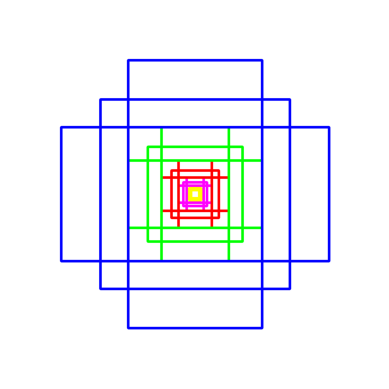

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

background = np.ones([1000, 1000, 3])*255
center = (500, 500)
colormap = [(255,255,0),(255,0,255),(255,0,0),(0,255,0),(0,0,255),]
anchors = model.rpn.anchor_generator.cell_anchors

i=0
for anchor in anchors:
    color = colormap[i%7]
    i+=1
    for x1,y1,x2,y2 in anchor:
        px1 = int(center[0] + x1)
        py1 = int(center[1] + y1)
        px2 = int(center[0] + x2)
        py2 = int(center[1] + y2)
        cv2.rectangle(background,(px1, py1),(px2, py2),color, 5)

plt.axis(False)
plt.imshow(background)

In [6]:
#torchvison.models.detection._utils.py 내 decode_single 함수 발췌

import torch
from torch import Tensor
import math

boxes = '앵커'
rel_codes = 'RPN 출력'

def decode_single(rel_codes: Tensor, boxes: Tensor) -> Tensor:
        """
        From a set of original boxes and encoded relative box offsets,
        get the decoded boxes.

        Args:
            rel_codes (Tensor): encoded boxes
            boxes (Tensor): reference boxes.
        """

        boxes = boxes.to(rel_codes.dtype)

        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights

        wx, wy, ww, wh = 1,1,1,1
        dx = rel_codes[:, 0::4] / wx
        dy = rel_codes[:, 1::4] / wy
        dw = rel_codes[:, 2::4] / ww
        dh = rel_codes[:, 3::4] / wh

        # Prevent sending too large values into torch.exp()
        dw = torch.clamp(dw, max=math.log(1000.0 / 16))
        dh = torch.clamp(dh, max=math.log(1000.0 / 16))

        pred_ctr_x = dx * widths[:, None] + ctr_x[:, None]
        pred_ctr_y = dy * heights[:, None] + ctr_y[:, None]
        pred_w = torch.exp(dw) * widths[:, None]
        pred_h = torch.exp(dh) * heights[:, None]

        # Distance from center to box's corner.
        c_to_c_h = torch.tensor(0.5, dtype=pred_ctr_y.dtype, device=pred_h.device) * pred_h
        c_to_c_w = torch.tensor(0.5, dtype=pred_ctr_x.dtype, device=pred_w.device) * pred_w

        pred_boxes1 = pred_ctr_x - c_to_c_w
        pred_boxes2 = pred_ctr_y - c_to_c_h
        pred_boxes3 = pred_ctr_x + c_to_c_w
        pred_boxes4 = pred_ctr_y + c_to_c_h
        pred_boxes = torch.stack((pred_boxes1, pred_boxes2, pred_boxes3, pred_boxes4), dim=2).flatten(1)
        return pred_boxes

rel_codes : [delta_x, delta_y, delta_width, delta_height] 


boxes : [x_min, y_min, x_max, y_max]

tensor([ 67,  21, 157, 203], dtype=torch.int32)
tensor([ 88,  26, 154, 161], dtype=torch.int32)


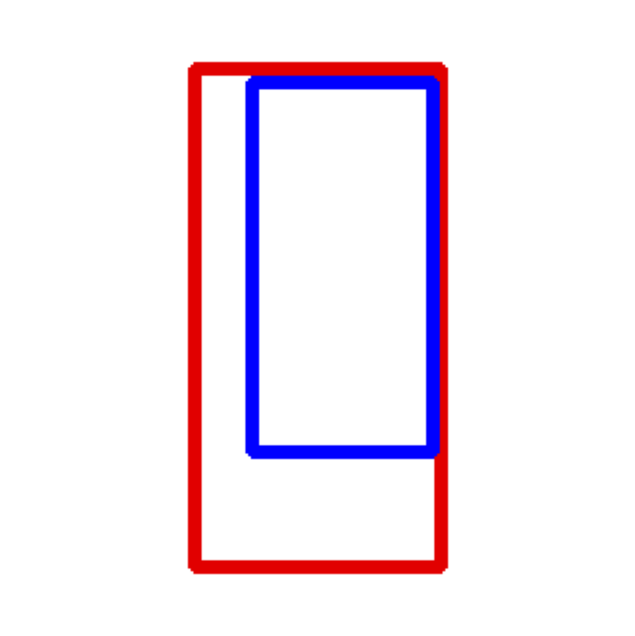

In [7]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

rel_codes = torch.tensor([[ 0.1, -0.1, -0.3, -0.3]])
boxes = torch.tensor([[-45., -91.,  45.,  91.]])
pred_boxes = decode_single(rel_codes, boxes)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

size = [225,225]
background = np.ones([size[0], size[1], 3], dtype=np.int32)*255
boxes = (boxes[0] + torch.tensor([p/2 for p in size]*2)).int()
pred_boxes = (pred_boxes[0] + torch.tensor([p/2 for p in size]*2)).int()

print(boxes)
print(pred_boxes)

# Original anchor box
cv2.rectangle(background,(boxes[0].item(), boxes[1].item()),(boxes[2].item(), boxes[3].item()),(225, 0, 0), 3)
# Predicted box
cv2.rectangle(background,(pred_boxes[0].item(), pred_boxes[1].item()),(pred_boxes[2].item(), pred_boxes[3].item()),(0, 0, 255), 3)


ax.set_axis_off()
ax.imshow(background)

<span style="font-size:150%">ROI 헤드</span>

In [8]:
print(model.roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=10, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=40, bias=True)
  )
)


In [9]:
import torch
import torchvision

model = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1'],
                                           output_size=(7,7),
                                           sampling_ratio=2)
i = dict()
i['0'] = torch.rand(1,256,64,64)
i['1'] = torch.rand(1,256,32,32)
boxes = torch.rand(3,4) * 256
boxes[:,2:] += boxes[:,:2]
image_sizes = [(512,512)]
output = model(i, [boxes], image_sizes)

print(boxes)
print(output.shape)
print(output.reshape([output.shape[0], -1]).shape)

tensor([[148.5877,  10.1488, 387.4478, 121.3020],
        [166.7858, 109.1978, 174.2077, 303.0258],
        [ 69.7791, 112.4345, 123.0808, 140.9216]])
torch.Size([3, 256, 7, 7])
torch.Size([3, 12544])


<span style="font-size:150%">손실 함수</span>

In [10]:
import os,sys
sys.path.append(os.path.abspath('./../'))

import torch
from datasets import PennFudanDataset
import coco.transforms as T


data_path = './data/PennFudanPed'
transform = T.Compose([T.PILToTensor(), 
                       T.ConvertImageDtype(torch.float)])
trainset = PennFudanDataset(data_path,transform)
sample, target = trainset[0]
sample = sample.unsqueeze(0)
target = [target]
model = fasterrcnn_resnet50_fpn(num_classes=10, weights=None, weights_backbone=None)
losses = model(sample, target)

print(list(losses.keys()))

['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']


<span style="font-size:150%">어그멘테이션</span>

In [11]:
h_flip = T.RandomHorizontalFlip(p=1)

data_path = './data/PennFudanPed'
trainset = PennFudanDataset(data_path, None)
sample, target = trainset[0]
print(target['boxes'])

new_sample, new_target = h_flip(sample, target)
print(new_target['boxes'])

tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])
tensor([[258., 181., 400., 430.],
        [ 25., 170., 140., 485.]])


tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])


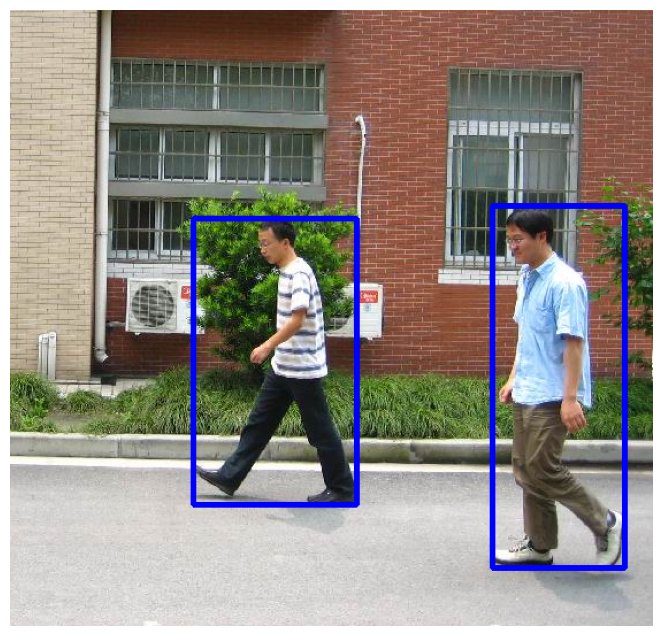

In [12]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline 

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

data_path = './data/PennFudanPed'
trainset = PennFudanDataset(data_path, transform)
sample, target = trainset[0]
print(target['boxes'])
sample = sample.permute(1,2,0).numpy()
sample = (sample*255).astype(int)

vis_sample = sample.copy()

for box in zip(target['boxes'].int()):
    box = box[0]
    cv2.rectangle(vis_sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(0, 0, 255), 3)
    
ax.set_axis_off()
ax.imshow(vis_sample)

tensor([[258., 181., 400., 430.],
        [ 25., 170., 140., 485.]])


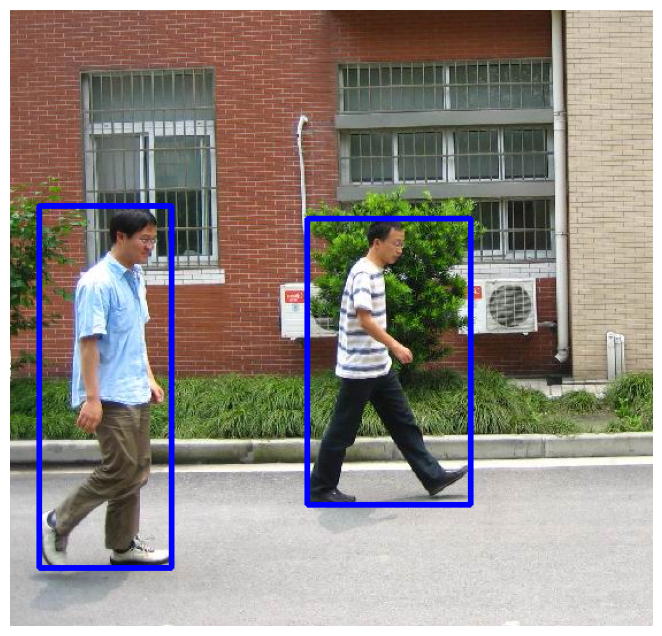

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

h_flip = T.RandomHorizontalFlip(p=1)

data_path = './data/PennFudanPed'
trainset = PennFudanDataset(data_path,transform)
sample, target = trainset[0]
new_sample, new_target = h_flip(sample, target)

print(new_target['boxes'])
new_sample = new_sample.permute(1,2,0).numpy()
new_sample = (new_sample*255).astype(int)

vis_sample = new_sample.copy()

for box in zip(new_target['boxes'].int()):
    box = box[0]
    cv2.rectangle(vis_sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(0, 0, 255), 3)
    
ax.set_axis_off()
ax.imshow(vis_sample)
